In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent = session.query(measurement).order_by(measurement.date.desc()).first()
recent.date


'2017-08-23'

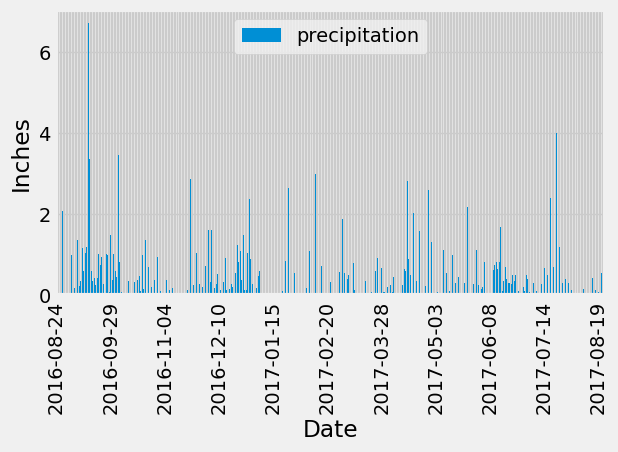

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year = dt.datetime.strptime(recent.date, '%Y-%m-%d')-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
Precipitation = session.query(measurement.date,func.max(measurement.prcp))\
                        .filter(measurement.date>=one_year)\
                        .filter(measurement.date<=recent.date)\
                        .group_by(measurement.date)\
                        .order_by(measurement.date)\
                        .all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data = pd.DataFrame(Precipitation,columns=['date','precipitation'])
data = data.set_index('date')

# Sort the dataframe by date
data = data.sort_values("date")
# Use Pandas Plotting with Matplotlib to plot the data
ax = data.plot.bar()
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
n = 36  # Keeps every 36th label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
plt.grid(visible=True)
plt.tight_layout()
plt.show()


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data['precipitation'].describe()

count    365.000000
mean       0.517288
std        0.829196
min        0.000000
25%        0.040000
50%        0.250000
75%        0.650000
max        6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
num_stations = session.query(station).count()
num_stations

9

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
Active = session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station).desc())\
    .all()
Active


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = Active[0][0]
calcs = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs))\
                        .filter(measurement.station == most_active).all()
(low,high,avg) = calcs[0]
print(f'Station: {most_active}')
print(f'Lowest Temperature: {low:.2f}')
print(f'Highest Temperature: {high:.2f}')
print(f'Average Temperature: {avg:.2f}')

Station: USC00519281
Lowest Temperature: 54.00
Highest Temperature: 85.00
Average Temperature: 71.66


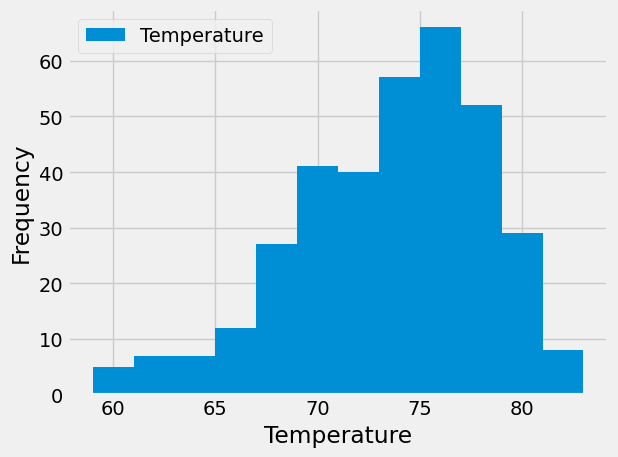

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histogram = session.query(measurement.tobs)\
                        .filter(measurement.date>=one_year)\
                        .filter(measurement.date<=recent.date)\
                        .filter(measurement.station == most_active).all()

df = pd.DataFrame(histogram,columns=['Temperature'])
df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.tight_layout()
plt.show()

# Close session

In [17]:
# Close Session
session.close()